# SARIMA

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from sklearn import metrics

import statsmodels.formula.api as smf 
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook 

import warnings                                  
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
source = pd.read_csv('E:\\Analytics\\Projects\\forecast_cargo_flow\\data\\sample_csu_since_2019.csv', delimiter=';')

Тестовый датасет содержит данные только по одному терминалу (28999900). Единицы измерения так же представлены в одном виде (экспресс накладные).
Тип потока имеет три значения, но для упрощения, мы сгруппируем данные только по дате. Соответсвеннно, остальные поля удалим.

In [4]:
df = source[['r_date', 'fact']] # оставляем только дату и факт
df = df.groupby('r_date').sum() # группируем по дате
df.reset_index(inplace=True) # сбрасываем индексы

df['r_date'] = pd.to_datetime(df['r_date'], format='%Y-%m-%d') # r_date в дату
df['r_date'] = pd.to_datetime(df["r_date"].dt.strftime('%Y-%m-%d'))

df['fact'] = pd.to_numeric(df['fact']) # факт в числовой тип

df.set_index(['r_date'], inplace=True)

In [5]:
df.head()

,fact
r_date,
2019-01-01,0
2019-01-02,2
2019-01-03,3391
2019-01-04,35128
2019-01-05,41658


In [6]:
def tsplot(y, lags=None, figsize=(23, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(r_date)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

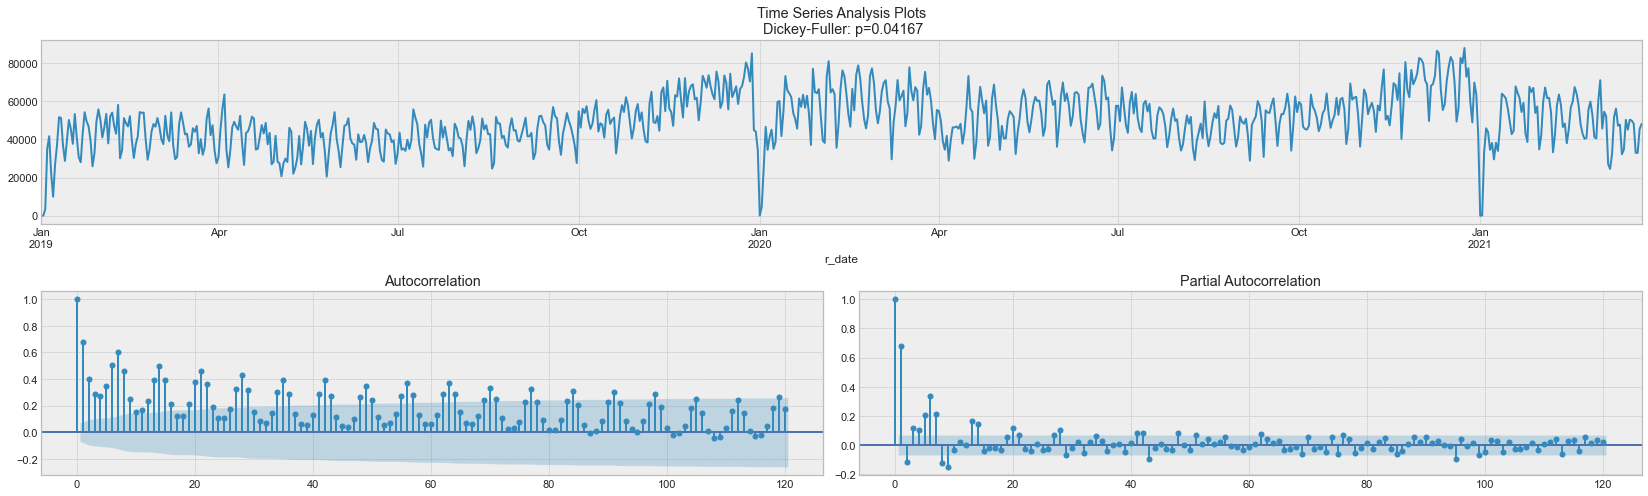

In [7]:
tsplot(df.fact, lags=120)

Этот ряд по критерию Дикки-Фуллера стационарен. Остаётся сезонность, с которой нужно разобраться перед построением модели. Для этого выполним преобразование "сезонное дифференцирование".

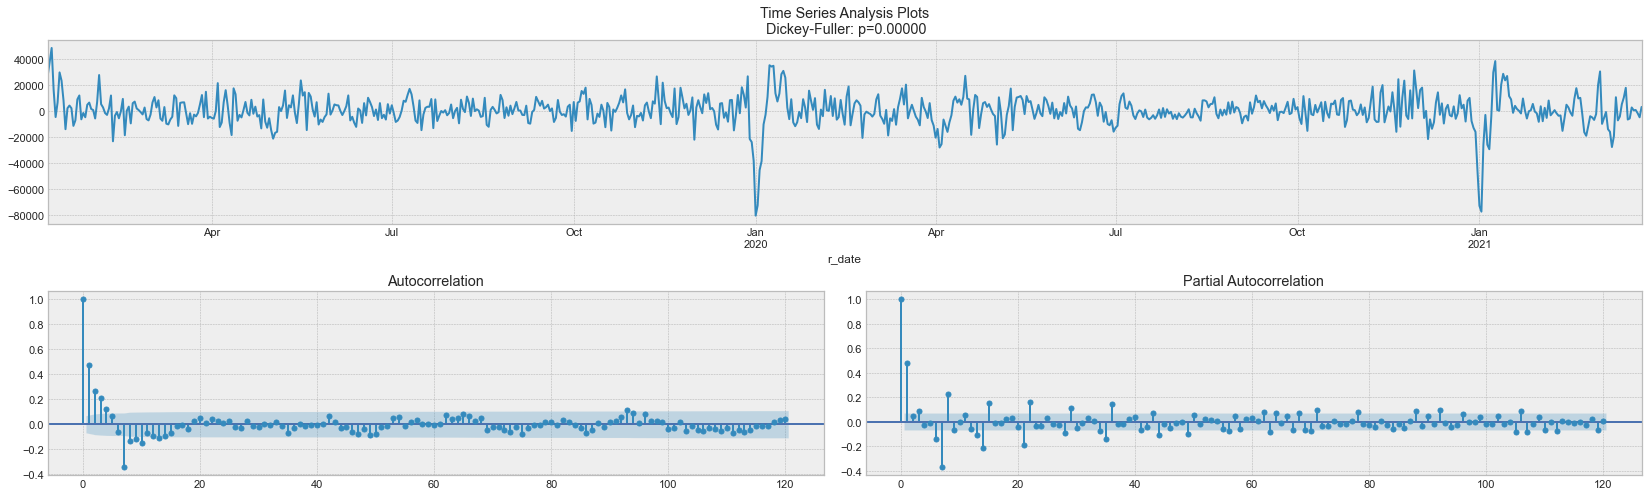

In [8]:
df_diff = df.fact - df.fact.shift(7)
tsplot(df_diff[7:], lags=120)

~~Уже лучше, от видимой сезонности избавились, в автокорреляционной функции по-прежнему осталось много значимых лагов, попробуем от них избавиться, взяв еще и первые разности - то есть вычитание ряда самого из себя с лагом в один шаг~~

In [9]:
# df_diff_2 = df_diff - df_diff.shift(1)
# tsplot(df_diff_2[7+1:], lags=120)

Отлично, теперь ряд выглядит как непонятно что, колеблющееся вокруг нуля, по критерию Дикки-Фуллера он стационарен, а в автокорреляционной функции пропали многочисленные значимые пики. Можно приступать к моделированию!

In [10]:
# p (6) - модель авторегрессии. Смотрим график частной автокорреляции, считаем значимые лаги не кратные сезонности
# q (6) - модель скользящего среднего. Модель коррекции. Смотрим автокорреляцию, логика таже, что и у р
# d (0) - интегрированность временного ряда, сколько обычных разностей надо взять, чтобы привести его к стационарному 
# s (7) - длина сезонности

# P (5,6,7) - значимые лаги, кратные сезонности. Смотрим на частную автокорреляцию, считаем значимые лаги кратные сезонности
# D (1) - порядок сезенной интегрированности ряда (берем ли сезонное дифференцирования)
# Q (1,2) -  скользящее среднее для сезонной компоненты

In [11]:
ps = range(5, 7)
d = 0
qs = range(5, 7)
Ps = range(0, 5)
D = 1
Qs = range(0, 3)
s = 7



parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [12]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df.fact, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [13]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 6min 26s


In [14]:
result_table.head(50)

,parameters,aic
0,"(6, 6, 0, 2)",16848.309322
1,"(6, 6, 1, 2)",16849.282903
2,"(6, 6, 0, 1)",16850.315461
3,"(6, 6, 1, 1)",16851.257328
4,"(6, 6, 2, 1)",16853.165165
5,"(6, 6, 4, 2)",16853.364609
6,"(6, 6, 2, 2)",16853.384390
7,"(6, 6, 3, 1)",16854.351989
8,"(6, 6, 3, 2)",16855.170750
9,"(6, 6, 4, 1)",16855.812318


In [15]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df.fact, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                   fact   No. Observations:                  814
Model:             SARIMAX(6, 0, 6)x(0, 1, [1, 2], 7)   Log Likelihood               -8409.155
Date:                                Thu, 08 Apr 2021   AIC                          16848.309
Time:                                        00:02:22   BIC                          16918.709
Sample:                                    01-01-2019   HQIC                         16875.343
                                         - 03-24-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7849      2.765     -0.284      0.776      -6.203       4.634
ar.

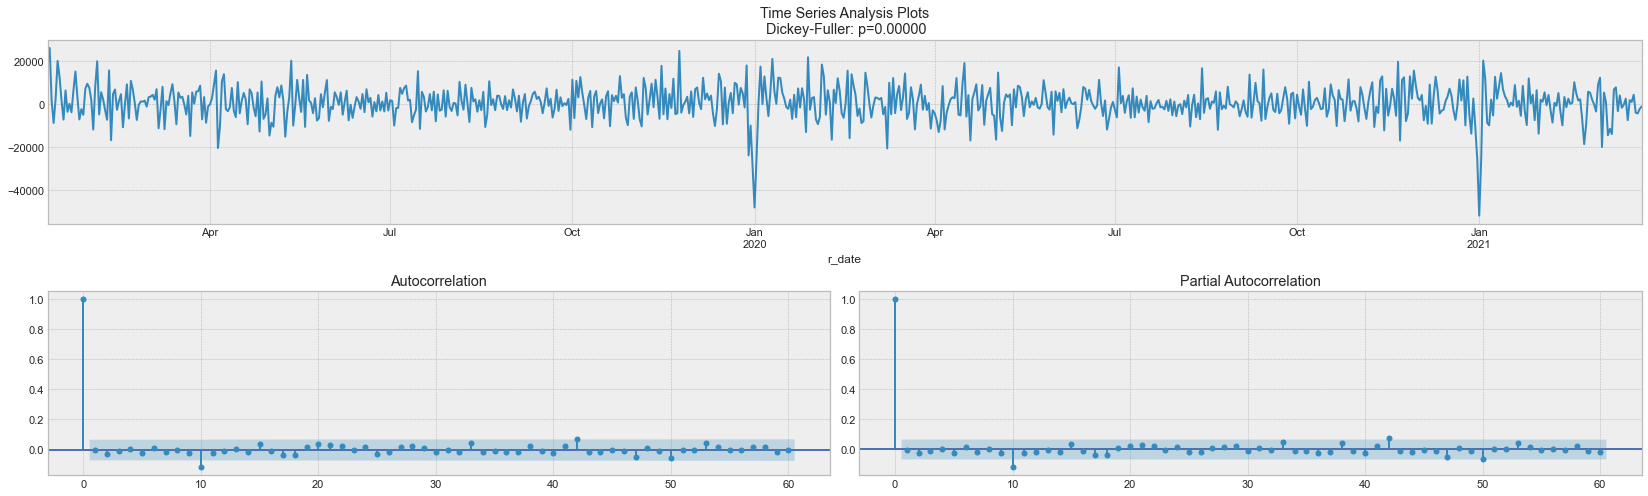

In [16]:
tsplot(best_model.resid[7+1:], lags=60)

Остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

In [17]:
def plotSARIMA(series, model, n_steps, s=7, d=0, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = best_model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    # error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    error = metrics.mean_absolute_error(data['actual'][s+d:], data['arima_model'][s+d:])
    

    plt.figure(figsize=(25, 7))
    plt.title("Mean Absolute Error: {0:.0f}".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True)

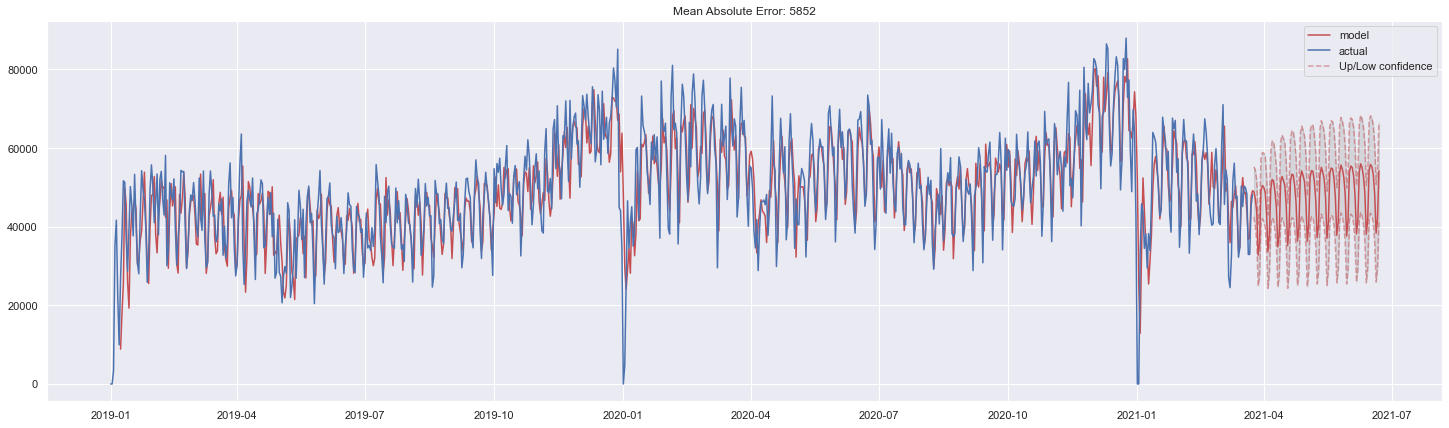

In [18]:
plotSARIMA(df, best_model, 90, alpha=0.5, plot_intervals=True)

# Auto SARIMA

In [19]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [20]:
train, test = train_test_split(df, train_size=770)

In [21]:
model = pm.auto_arima(train, start_p=4, start_q=2, start_P=5, start_Q=1, max_p=7, max_q=7, max_P=7, m=7, seasonal=True, d=0, D=1, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(4,0,2)(5,1,1)[7] intercept   : AIC=15967.722, Time=12.32 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=16457.313, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=16121.049, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=16111.899, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=16456.039, Time=0.02 sec
 ARIMA(4,0,2)(4,1,1)[7] intercept   : AIC=inf, Time=7.25 sec
 ARIMA(4,0,2)(5,1,0)[7] intercept   : AIC=15992.412, Time=5.12 sec
 ARIMA(4,0,2)(6,1,1)[7] intercept   : AIC=15968.651, Time=16.34 sec
 ARIMA(4,0,2)(5,1,2)[7] intercept   : AIC=inf, Time=11.56 sec
 ARIMA(4,0,2)(4,1,0)[7] intercept   : AIC=16014.531, Time=3.18 sec
 ARIMA(4,0,2)(4,1,2)[7] intercept   : AIC=inf, Time=7.42 sec
 ARIMA(4,0,2)(6,1,0)[7] intercept   : AIC=15990.817, Time=7.47 sec
 ARIMA(4,0,2)(6,1,2)[7] intercept   : AIC=inf, Time=14.43 sec
 ARIMA(3,0,2)(5,1,1)[7] intercept   : AIC=15972.794, Time=7.58 sec
 ARIMA(4,0,1)(5,1,1)[7] intercept   : A

In [22]:
forecasts = model.predict(test.shape[0])

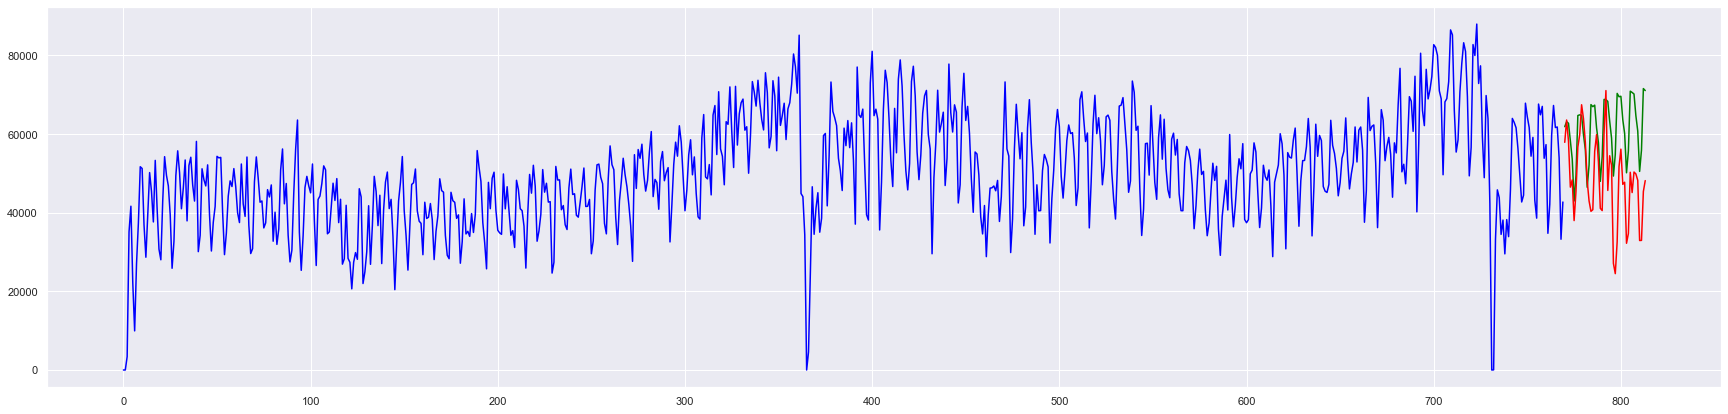

In [23]:
x = np.arange(df.shape[0])
plt.figure(figsize=(30,7))
plt.plot(x[:770], train, c='blue')
plt.plot(x[770:], forecasts, c='green')
plt.plot(x[770:], test, c='red')
plt.show()

In [24]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df)
print(p_val, should_diff)

0.01 False


In [25]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(df.fact, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(df.fact, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


(array([  7.,   1.,  13.,  86., 162., 223., 160., 105.,  43.,  14.]),
 array([    0. ,  8797.8, 17595.6, 26393.4, 35191.2, 43989. , 52786.8,
        61584.6, 70382.4, 79180.2, 87978. ]),
 <BarContainer object of 10 artists>)

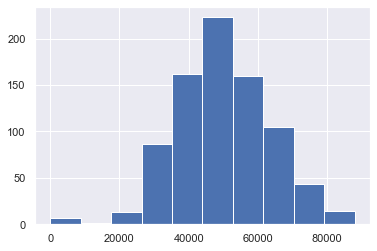

In [26]:
plt.hist(df.fact)